# Additional explorations with scene classification

Data consists of 150x150 pictures of scenes from real-world classified into 6 classes: ['building','forest','glacier','mountain','sea','street'].  Data is separated into training, validation and test directories.

In [ ]:
from subprocess import check_output
print(check_output(["ls", "../input/intel-image-classification"]).decode("utf8"))


In [ ]:
import matplolib.pyplot as plt

fig = plt.subplots(1, 4, figsize=(15,5))


### Model building

In [ ]:


from keras import layers, models

m1 = models.Sequential()
m1.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
m1.add(layers.MaxPooling2D((2,2)))
m1.add(layers.Conv2D(64, (3,3), activation = 'relu'))
m1.add(layers.MaxPooling2D((2,2)))
m1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
m1.add(layers.MaxPooling2D((2,2)))
m1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
m1.add(layers.MaxPooling2D((2,2)))
m1.add(layers.Flatten())
m1.add(layers.Dense(512,activation='relu'))
m1.add(layers.Dense(6,activation = 'softmax'))

m1.summary()
from keras import optimizers

m2 = m1
m1.compile(loss='categorical_crossentropy',
             optimizer = optimizers.Adam(lr=1e-04),
             metrics=['acc'])
m2.compile(loss='categorical_crossentropy',
             optimizer = optimizers.SGD(lr=1e-04,momentum=0.9),
             metrics=['acc'])

### Data Preprocessing

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = '../input/intel-image-classification'

train_dir = os.path.join(base_dir,'seg_train/seg_train')
valid_dir = os.path.join(base_dir,'seg_test/seg_test')
test_dir = os.path.join(base_dir,'seg_pred/seg_pred')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150,150),
                                                   batch_size = 6,
                                                   class_mode = 'categorical')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size = (150,150),
                                                   batch_size = 6,
                                                   class_mode = 'categorical')

for data_batch, labels_batch in train_generator:
    print('db shape', data_batch.shape)
    print('lb shape', labels_batch.shape)
    break

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
db shape (6, 150, 150, 3)
lb shape (6, 6)


In [ ]:

history = m1.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 40,
                             validation_data = valid_generator,
                             validation_steps = 100)
m1.save('ii_1.h5')


In [ ]:
import pickle
hist_dump = open('ii2_sgd_HistoryDict.pickle', 'wb')
pickle.dump(history.history, hist_dump)
hist_dump.close()

In [ ]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'b', label='Train accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'b', label="Train loss")
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [ ]:
history = m2.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 40,
                             validation_data = valid_generator,
                             validation_steps = 100)
m2.save('ii_3.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'b', label='Train accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
plt.title('Training & Validation Accuracy for SGD + mom Model')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'b', label="Train loss")
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training & Validation Loss for SGD + mom Model')
plt.legend()

plt.show()

In [ ]:

img_path = test_dir + '1512.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

#plt.imshow(img_tensor[0])
#plt.show()

from keras.models import load_model 
#from keras import models

#m1 = load_model('cd_1.h5')
print(m1.predict(img_tensor))



### Exploring Weight Initialization

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = 'C:/Sandeep/Learning/NNDL-GC/HW/HW3/intel-image'

train_dir = os.path.join(base_dir,'seg_train')
valid_dir = os.path.join(base_dir,'seg_test')
test_dir = os.path.join(base_dir,'seg_pred')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150,150),
                                                   batch_size = 6,
                                                   class_mode = 'categorical',
                                                   shuffle=True)
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size = (150,150),
                                                   batch_size = 6,
                                                   class_mode = 'categorical',
                                                  shuffle=True)

for data_batch, labels_batch in train_generator:
    print('db shape', data_batch.shape)
    print('lb shape', labels_batch.shape)
    break

Using TensorFlow backend.


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
db shape (6, 150, 150, 3)
lb shape (6, 6)


In [ ]:
# Exploring weight initialization for the first model's architecture (using Adam optimizer)
# but changing various initialization schemes
def build_model(initializer): 
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3),
                           kernel_initializer=initializer))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(6,activation = 'softmax'))

    #model.summary()
    return model

# For the following test of weight initialization I am using small parts of code from
# Daniel Godoy author of package DeepReplay: https://github.com/dvgodoy/deepreplay

from deepreplay.callbacks import ReplayData
from deepreplay.replay import Replay
from deepreplay.plot import compose_plots
from keras.initializers import normal
from matplotlib import pyplot as plt
from deepreplay.datasets.ball import load_data

# Load random data for testing initialization for each architecture
X, y = load_data(n_dims=10)

# Normal initializer
init = normal(mean=0, stddev=0.01, seed=13)
m3 = build_model(init)

# Testing architecture without training
replaydata = ReplayData(X, y, filename="filename", group_name="group_name", model=m3)

# Now we feed the data to the actual Replay object
# so we can build the visualizations
replay = Replay(replay_filename="filename", group_name="group_name")

# Using subplot2grid to assemble a complex figure...
fig = plt.figure(figsize=(12, 6))
ax_zvalues = plt.subplot2grid((2, 2), (0, 0))
ax_weights = plt.subplot2grid((2, 2), (0, 1))
ax_activations = plt.subplot2grid((2, 2), (1, 0))
ax_gradients = plt.subplot2grid((2, 2), (1, 1))

wv = replay.build_weights(ax_weights)
gv = replay.build_gradients(ax_gradients)
# Z-values
zv = replay.build_outputs(ax_zvalues, before_activation=True, 
                          exclude_outputs=True, include_inputs=False)
# Activations
av = replay.build_outputs(ax_activations, exclude_outputs=True, include_inputs=False)

# Finally, we use compose_plots to update all
# visualizations at once
fig = compose_plots([zv, wv, av, gv], 
                    epoch=0, 
                    title=r'Activation: sigmoid - Initializer: Normal $\sigma = 0.01$')

### Learning rate

It is apparent from the loss plots for the models above that the learning rate flattens after about 15 iterations. For this purpose, the following options will be explored using the SGD + momentum model:
- multiple learning rates
- learning rate multiplier after every 15 iterations ???
- learning rate decay

In [ ]:
import matplotlib.pyplot as plt
from keras import layers, models, optimizers

# Exploring learning decay for the second model's architecture (using SGD + momentum optimizer)

def build_model_decay(lrate, decay): 
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(6,activation = 'softmax'))

    #model.summary()
    model.compile(loss='categorical_crossentropy',
             optimizer = optimizers.SGD(lr=lrate,momentum=0.9,decay=decay),
             metrics=['acc'])
    
    return model

decay_rate = [0.1,0.01,0.001]

for i in range(len(decay_rate)):
    plot_num = 310+i+1
    plt.subplot(plot_num)
    m_lr = build_model_decay(decay_rate[i],0.0001) # learning rate fixed at 0.0001
    history = m_lr.fit_generator(train_generator,
                                 steps_per_epoch = 100,
                                 epochs = 40,
                                 validation_data = valid_generator,
                                 validation_steps = 100, verbose=0)
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc, 'b', label='Train accuracy')
    plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
    plt.title('Accuracy w/ lrate='+str(lr), pad=50)
    plt.legend()



    plt.show()


### Dropout Parameters

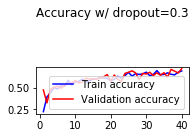

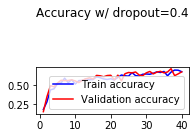

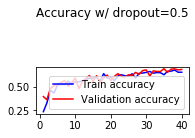

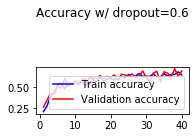

In [3]:
import matplotlib.pyplot as plt
from keras import layers, models, optimizers

# Exploring dropout parameters for the second model's architecture (using SGD + momentum optimizer)

def build_model_drop(lrate, decay, do_para): 
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(do_para))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(6,activation = 'softmax'))

    #model.summary()
    model.compile(loss='categorical_crossentropy',
             optimizer = optimizers.SGD(lr=lrate,momentum=0.9,decay=decay),
             metrics=['acc'])
    
    return model

dropout_para = [0.3,0.4,0.5,0.6]

for i in range(len(dropout_para)):
    plot_num = 420+i+1
    plt.subplot(plot_num)
    m_lr = build_model_drop(0.001,0.0001,dropout_para[i]) # learning rate fixed at 0.0001 & decay at 0.001
    history = m_lr.fit_generator(train_generator,
                                 steps_per_epoch = 100,
                                 epochs = 40,
                                 validation_data = valid_generator,
                                 validation_steps = 100, verbose=0)
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc, 'b', label='Train accuracy')
    plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
    plt.title('Accuracy w/ dropout='+str(dropout_para[i]), pad=50)
    plt.legend()



    plt.show()


### Confusion matrix for model with better learning, decay rate and dropout

Based on the analysis on learning rate, decay rate and dropout parameters, a model is built with the hyperparameters that gave the best results. To check the predictive power of this model, the new model is trained and confusion matrix is plotted.

C:\Anaconda3\envs\tf\lib\site-packages\keras\callbacks\tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


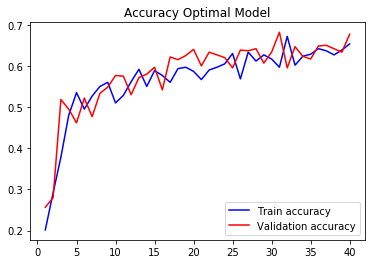

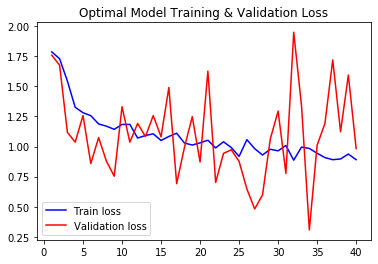

In [10]:
from keras.callbacks import TensorBoard
import keras.initializers as ki
import os

log_dir = os.path.join('logs')
tb = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=True,
                         write_grads=True,profile_batch=100000)

initializer = ki.Orthogonal(seed=13)
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3),
                       kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu',
                       kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu',
                       kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu',
                       kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu',
                       kernel_initializer=initializer))
model.add(layers.Dense(6,activation = 'softmax',
                       kernel_initializer=initializer))

#model.summary()
model.compile(loss='categorical_crossentropy',
         optimizer = optimizers.SGD(lr=0.001,momentum=0.9,decay=0.001),
         metrics=['acc'])
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 40,
                             validation_data = valid_generator,
                             validation_steps = 100, verbose=0,
                             callbacks=[tb])

model.save('ii_opt_hyper.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'b', label='Train accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy Optimal Model')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'b', label="Train loss")
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Optimal Model Training & Validation Loss')
plt.legend()



In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

test_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=32)

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict_generator(test_generator,steps = nb_samples/32)

test_labels = test_generator.labels

cm = confusion_matrix(np.argmax(predictions, axis=1), test_labels)

print (cm)

plt.figure(figsize = (15, 15))

name_labels = [
    'buildings',
    'forest',
    'glacier',
    'mountain',
    'sea',
    'street'
]
plt.show()

In [32]:

cm = confusion_matrix(np.argmax(predictions, axis=1), test_labels)
print (cm)


[[253  11  16  24  22  62]
 [ 21 396   4   3   5  25]
 [ 38   4 405  74 194  26]
 [ 34   7  78 372 116   8]
 [  6   1  38  46 167   3]
 [ 85  55  12   6   6 377]]


#### Comment based on confusion matrix 
It can be seed from the confusion matrix above that the model with "better" hyperparameters (learning rate, decay rate, dropout) can classify 'glacier' (third class) most accurately. However, 'sea' (fifth class) cannot be identified very well. 

### Data Augmentation & DropOut
The above model is overfit as shown by the huge gap between training & validation accuracy and inconsistent validation loss. The solution would be to apply data augmentation & add dropout to the model

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150,150),
                                                   batch_size = 32,
                                                   class_mode = 'binary')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size = (150,150),
                                                   batch_size = 32,
                                                   class_mode = 'binary')


In [ ]:
# New model with dropout
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer = optimizers.Adam(lr=1e-04,beta_1=0.9, beta_2=0.999),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 50,
                             validation_data = valid_generator,
                             validation_steps = 50)
model.save('cd_drop_aug.h5')


In [ ]:
hist_dump = open('cd_dropAug_HistoryDict.pickle', 'wb')
pickle.dump(history.history, hist_dump)
hist_dump.close()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc, 'b', label='Train accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation accuracy')
plt.title('New Model Training & Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'b', label="Train loss")
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('New Model Training & Validation Loss')
plt.legend()

plt.show()

## Visualizing 

In [ ]:
# Import test data

import os, shutil
full_image_dir = 'cats_dogs_data/full'
base_dir = 'cats_dogs_data'

cats_test_dir = os.path.join(os.path.join(base_dir,'test'),'cats')
dogs_test_dir = os.path.join(os.path.join(base_dir,'test'),'dogs')

    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(full_image_dir,fname)
    dest = os.path.join(cats_test_dir,fname)
    shutil.copyfile(src,dest)

    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(full_image_dir,fname)
    dest = os.path.join(dogs_test_dir,fname)
    shutil.copyfile(src,dest)


In [ ]:
# import example image for channel activation map visualization
img_path = 'cats_dogs_data/test/dogs/dog.1512.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras.models import load_model 
from keras import models

m2 = load_model('cd_drop_aug.h5')
layer_outputs = [layer.output for layer in m2.layers[:8]]
activation_model = models.Model(inputs=m2.input, output=layer_outputs)
activations = activation_model.predict(img_tensor)

layer_names = []
for layer in m2.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,
                                            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size,
                        row*size:(row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize = (scale*display_grid.shape[1],
                         scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

Each channel extracts specific features from the images. Channel 4 (fourth column images) highlights that the channel can identify eyes. Channel 3, 5 seems to be identifying lines better.

## Visualizing Filters

In [ ]:
from keras import backend as K

# funciton to convert a tensor to image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x,0,1)
    
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(filter_ind, size=150):
    
    layer_output = m2.get_layer('conv2d_25').output # using layer max_pooling2d_28
    loss = K.mean(layer_output[:,:,:,filter_ind]) # getting loss for first filter

    grads = K.gradients(loss,m2.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-05) # normalizing gradients with its L2 norm

    # Getting loss and gradient tensors from the DL model
    iterate = K.function([m2.input], [loss,grads])
    #loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

    input_img_data = np.random.random((1,size,size,3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    
    return deprocess_image(img)

#    plt.imshow(deprocess_image(img))

In [ ]:
margin = 5
size = 150
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern( i+(j*8), size)
        
        hor_start = i*size + i*margin
        hor_end = hor_start + size
        ver_start = j*size + j*margin
        ver_end = ver_start + size
        results[hor_start:hor_end,
               ver_start:ver_end,
               :] = filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)